In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import glob
import os

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fec787', '#fb9d32']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [7]:
def bootstrap_median_ci(data, n_bootstrap=1000, ci=95):
    """
    Compute bootstrapped confidence intervals for the median along the last axis.

    Parameters:
    - data: np.ndarray, with the last axis as different runs/seeds.
    - n_bootstrap: number of bootstrap samples to draw.
    - ci: confidence level (e.g., 95 for 95% CI).

    Returns:
    - medians: median along the last axis.
    - ci_lower: lower bound of confidence interval.
    - ci_upper: upper bound of confidence interval.
    """
    shape = data.shape[:-1]
    medians = np.median(data, axis=-1)
    ci_lower = np.zeros(shape)
    ci_upper = np.zeros(shape)
    se_median = np.zeros(shape)

    it = np.nditer(medians, flags=['multi_index'])
    while not it.finished:
        idx = it.multi_index
        sample = data[idx]
        boot_medians = np.array([
            np.median(np.random.choice(sample, size=len(sample), replace=True))
            for _ in range(n_bootstrap)
        ])
        lower = (100 - ci) / 2
        upper = 100 - lower
        ci_lower[idx] = np.percentile(boot_medians, lower)
        ci_upper[idx] = np.percentile(boot_medians, upper)
        se_median[idx] = np.std(boot_medians, ddof=1)  # bootstrap standard error
        it.iternext()

    return medians, ci_lower, ci_upper, se_median

In [8]:
from utils.modules import net

In [166]:
# 3 differeny settings: full, EI, and small N

np.random.seed(0)

N = 1000
N2 = 100 # 510 for mid N

J = []
J.append(np.random.randn(N, N) / np.sqrt(N))

ExcFrac = (N - N2) / N
InhFrac = 1 - ExcFrac
ExcSig = 0.1
InhSig = np.sqrt((1 - ExcSig ** 2 * ExcFrac) / InhFrac)
print(ExcSig)
print(InhSig)
print(np.sqrt(ExcSig/InhSig))
JExc = np.random.randn(N, np.round(N * ExcFrac).astype(int)) / np.sqrt(N) * ExcSig
JInh = np.random.randn(N, np.round(N * InhFrac).astype(int)) / np.sqrt(N) * InhSig
J.append(np.hstack((JExc, JInh)))

J.append(np.random.randn(N2, N2) / np.sqrt(N2))

0.1
3.148015247739439
0.1782303198097613


In [169]:
f = ExcFrac
alpha = (InhSig/ExcSig) ** (2)
rmax = np.sqrt(1-f+f/alpha)

# analytical expression for the eigenmode historgam
# source: 
### Rajan, Kanaka, and L. F. Abbott. ‘Eigenvalue Spectra of Random Matrices for Neural Networks’. Physical Review Letters 97, no. 18 (2 November 2006): 188104.
### https://doi.org/10.1103/PhysRevLett.97.188104.

def EI_density(w2):
    t1 = (1-alpha)*w2-1
    t2 = t1 ** 2 + 4 * f * (1-alpha)*w2
    q = (t1 + 2 * f)/(2-2*f) + np.sqrt(t2)/(2-2*f)
    
    q1 = (1-alpha)/(2-2 * f) * (1 + (t1 + 2 * f) / (np.sqrt(t2)))
    q2 = (1-alpha) ** 2 / ((2 - 2 * f) * (np.sqrt(t2))) * (1 - (t1 + 2 * f) ** 2 / t2)

    t3 = 1/(q+1) - f/q + alpha*w2/(q+1) - w2*(alpha*q+1)/(q+1)**2
    
    phi1 = q1*t3 + (alpha*q+1)/(q+1)
    phi2 = q2*t3 + 2*q1*(alpha/(q+1)-(alpha*q+1)/(q+1)**2) +q1**2*(-1/(q+1)**2+f/q**2-2*alpha*w2/(q+1)**2 + 2*w2*(alpha*q+1)/(q+1)**3)

    return 1/np.pi * (w2 * phi2 + phi1)

Text(0, 0.5, 'density of eigenmodes')

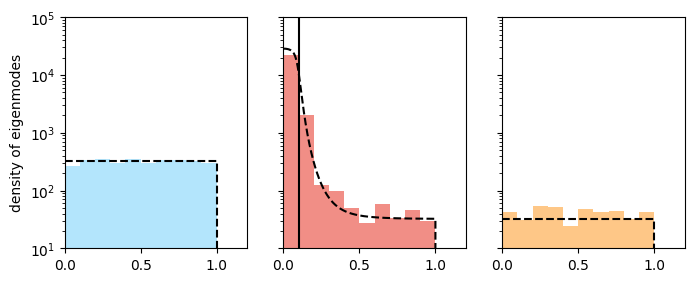

In [190]:
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (8,3))
for i in range(3):
    e_val, e_vec = np.linalg.eig(J[i])
    rs = np.abs(e_val)
    r_grid = np.linspace(0, 1.0, 11)
    dr = r_grid[1] - r_grid[0]
    hist, bins = np.histogram(rs, bins = r_grid)
    r_cent = (r_grid[1:] + r_grid[:-1])/2
    
    axes[i].bar(r_grid[:-1], hist / (2 * np.pi * r_cent) / dr, width=dr, align='edge', color=colors[i][0], bottom=1e1)
    # axes[i].plot(r_cent, hist / (2 * np.pi * r_cent))
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e1, 1e5)
    axes[i].set_xlim(0, 1.2)

rho1 = N/(np.pi)
axes[0].plot([0,1,1], [rho1, rho1, 1], color = 'black', linestyle = 'dashed')

rEI = np.linspace(0,1,1000)[1:]
wEI = rEI * rmax
drEI = rEI[1] - rEI[0]
rho2 = N * EI_density(wEI ** 2)*rmax**2
axes[1].plot([*rEI, 1], [*rho2, 1], color = 'black', linestyle = 'dashed')
# axes[1].axvline(InhFrac, color = 'black')

rho3 = N2/(np.pi)
axes[2].plot([0,1,1], [rho3, rho3, 1], color = 'black', linestyle = 'dashed')

axes[0].set_ylabel('density of eigenmodes')
# plt.savefig('spectrahists.pdf')

747
76
77


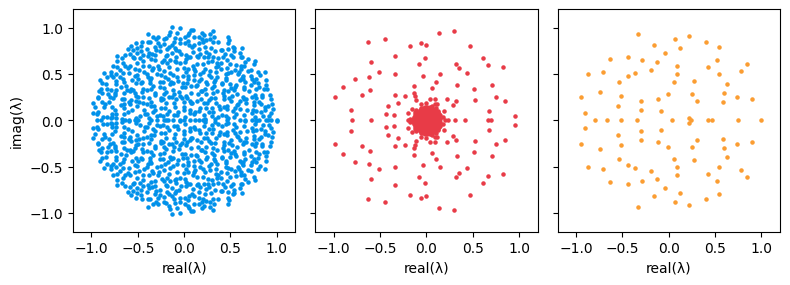

In [181]:
fig, axes = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (8,3))
for i in range(3):
    e_val, e_vec = np.linalg.eig(J[i])
    axes[i].set_aspect(1)
    axes[i].scatter(np.real(e_val), np.imag(e_val), s = 5, color = colors[i][1])
    rr = np.sqrt(np.real(e_val) ** 2 + np.imag(e_val) ** 2)
    print(np.sum(rr > 0.5))
    axes[i].set_xlabel('real(λ)')
    axes[i].set_xlim(-1.2, 1.2)
    axes[i].set_ylim(-1.2, 1.2)
axes[0].set_ylabel('imag(λ)')
plt.tight_layout()

In [183]:
# render border-less plots
saving = False
for i in range(3):
    fig = plt.figure(figsize=(4, 4), dpi=300)
    e_val, e_vec = np.linalg.eig(J[i])
    plt.axes().set_aspect(1)
    plt.scatter(np.real(e_val), np.imag(e_val), s = 20, color = colors[i][1])
    rr = np.sqrt(np.real(e_val) ** 2 + np.imag(e_val) ** 2)
    print(np.sum(rr > 0.5))
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.axis('off')
    
    # Save without extra white space
    if saving:
        plt.savefig(f"spectra_{i}.png", dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()

747
76
77


In [191]:
# define target function params
target_amplitdes = np.logspace(-1, 1, 50) # np.logspace(-1, 2, 20) for non-dense sweep
target_period = 50 # 10 for small T

# define total training and testing time
t_train = 400 # 100 for small T
t_test = 200 # 100 for small T

seeds = np.arange(0, 100)

In [6]:
# def run_one(inputs):
#     seed = inputs[0]
#     k = inputs[1]
#     i = inputs[2]
#     #ct = 0
#     MSE = []
#     filename = f'data/sweep_NnEI_k{k:02d}_seed{seed:03d}_amp{i:03d}.npy'
#     if os.path.isfile(filename):
#         return 0
# 
#     target_amplitde = target_amplitdes[i]
#     
#     target = lambda x: target_amplitde * np.sin(2 * np.pi * x / target_period)
#     t0 = time.time()
#     
#     if k == 0:
#         network = net(N = N, seed = seed + k * 100 + i * 1000)
#         np.random.seed(seed + k * 10000 + i * 100000)
#         network.J = np.random.randn(N, N) / np.sqrt(N)
#     elif k == 1:
#         network = net(N = N, seed = seed + k * 100 + i * 1000)
#         np.random.seed(seed + k * 10000 + i * 100000)
#         JExc = np.random.randn(N, np.round(N * ExcFrac).astype(int)) / np.sqrt(N) * ExcSig
#         JInh = np.random.randn(N, np.round(N * InhFrac).astype(int)) / np.sqrt(N) * InhSig
#         network.J = np.hstack((JExc, JInh))
#     else:
#         network = net(N = N2, seed = seed + k * 100 + i * 1000)
#         np.random.seed(seed + k * 10000 + i * 100000)
#         network.J = np.random.randn(N2, N2) / np.sqrt(N2)
#     
#     res_train = network.simulate_train(t_train, target)
#     res_test = network.simulate_test(t_train + t_test, target, t_ini = t_train)
# 
#     test_time = res_test[0]
#     test_output = res_test[4][:, 0]
#     ideal_output = target(test_time)
#     
#     MSE.append(np.sqrt(np.mean((ideal_output - test_output) ** 2)) / target_amplitde)
#     
#     #print(f'finished {ct:03d}-th run in {time.time() - t0:.3f}s', end = '\r')
#     #ct += 1
# 
#     with open(filename, 'wb') as f:
#         np.save(f, MSE)

In [7]:
# INPUTS = []
# for seed in seeds:
#     for k in range(3):
#         for amp in range(len(target_amplitdes)):
#             INPUTS.append([seed, k, amp])

In [34]:
# no multiprocessing

# for inp in INPUTS:
#     run_one(inp)

In [ ]:
# multiprocessing

# from multiprocessing import Pool
# 
# if __name__ == '__main__':
#     
#     pool = Pool()
#     INPUTS = []
#     for seed in seeds:
#         for k in range(3):
#             INPUTS.append([seed, k])
# 
#     pool.map(run_one, INPUTS, chunksize = 1)
#     pool.terminate()

In [36]:
# data processing

# datas = glob.glob('data/sweep_NnEI_k*')

In [37]:
# MSE = np.zeros((len(target_amplitdes), 3, len(seeds)))

# for data in datas:
#     k = int(data.split('_')[-3][1:3])
#     sd = int(data.split('_')[-2][-3:])
#     amp = int(data.split('_')[-1][3:6])
#     with open(data, 'rb') as f:
#         MSE[amp, k, sd] = np.load(f)[0]
#     os.remove(data)

# with open('data/sweep_NnEI.npy', 'wb') as f:
#     np.save(f, MSE)

In [192]:
with open('data/sweep_NnEI.npy', 'rb') as f:
    MSE = np.load(f)

err_avg = np.mean(MSE, axis = -1)
err_std = np.std(MSE, axis = -1) / np.sqrt(len(seeds))

medians, ci_lower, ci_upper, se_median = bootstrap_median_ci(MSE)

In [193]:
pltavg = medians
plterr = se_median

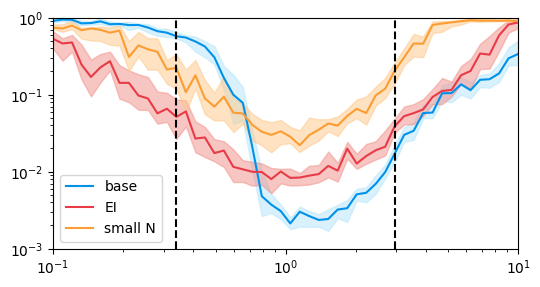

In [197]:
slices = [13, 36]

plt.figure(figsize = (6, 3))
(amps, ks, sds) = MSE.shape
for i in range(ks):
    #for j in range(10):
    #    plt.scatter(target_amplitdes, MSE[:, i, j], color = colors[i][0], alpha = 1, s = 8)
    plt.plot(target_amplitdes, medians[:, i], color = colors[i][1], label = ['base', 'EI', 'small N'][i])
    plt.fill_between(target_amplitdes,
                     ci_lower[:, i],# pltavg[:, i] + plterr[:, i],
                     ci_upper[:, i],#pltavg[:, i] - plterr[:, i],
                     color = colors[i][0], alpha = 0.5)
for s in slices:
    plt.axvline(target_amplitdes[s], linestyle = 'dashed', color = 'black')
    
#plt.axvline(target_period / 2, color = 'black')
plt.legend()
plt.xlim(1e-1, 1e1)
plt.ylim(1e-3, 1e0)
plt.yscale('log')
plt.xscale('log')
#plt.xlabel('Δt')
#plt.ylabel('η', rotation = 0)
#plt.savefig('NnEI_SWEEP.pdf')